# Predicting the Fare on a Billion Taxi Trips in BigQuery


<br><br><br>

<div style="text-align: center;">
    <img src="images/cars_wide.jpeg" width="90%" style="border-radius: 10px;">
</div>


<br><br>


How long time does it take and how much does it cost to analyse and train a model on a billion taxi trips in the cloud? When do most trips occur, what affects the total fare amount the most and how accurately can we predict it?

Google's BigQuery makes it straight forward to analyse the data before applying machine learning to it. We will use the publicly available [cab rides dataset](https://console.cloud.google.com/marketplace/browse?q=nyc%20tlc%20trips&filter=solution-type:dataset) for New York City, which includes over 1.1 billion rides between 2009 and 2015. Due to the size of the dataset, we will initially work on a small fraction of it to facilitate visualisation and save on query costs. Once we've developed a good understanding of the data we'll train a model on all 1 billion samples. Lastly, we will use the model to make predictions and analyse the errors.


<br><br>

#### The notebook became longer than I first expected, so here's a very short summary: <br>

> *It took around 21 minutes to train a linear regression model on the full dataset at a total cost of less than $20*.


<br><br>

<a name="top"></a>

## Index

- [Exploratory Data Analysis](#eda)
    - [Categorical Variables](#categorical)
    - [Continuous Variables](#continuous)
    - [Correlation between Features and Total Trip Amount](#correlation)
    - [Display Pickup and Dropoff Locations on a Map](#map)
    - [Query the Data with above Constraints](#query_constraints)
- [Machine Learning with BigQuery ML](#BigQueryML)
    - [Create a Data Table for ML and Exclude Irrelevant Values](#data_table_small)
    - [Model 1: Three Features only](#model_1)
    - [Model 2: Include another Five Features](#model_2)
    - [Model 3: Include Datetime Features](#model_3)
    - [Model 4: Feature Engineering](#model_4)
    - [Model 5: Add Regularisation and Tune Model](#model_5)
- [Train on All the Data](#all_data)
    - [Create a Data Table using All the Data](#all_data_table)
    - [Train Model on All the Data](#model_all)
- [RMSE Model Summary](#model_summary)
- [Model Prediction and Analysis](#predictions)
- [Summary](#summary)


<br><br>

In [3]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()

<a name="eda"></a>

## [Exploratory Data Analysis](#top)

Start by querying 1 in 10,000 rows of the data using BigQuery, keeping a subset of the columns only. Since the dataset consist of a little more than 1 billion records, we will end up with just north of 100,000 rows. This size will be small enough to facilitate data visualisation while probably large enough to represent the entire dataset pretty well. This is how the query looks like:


In [3]:
%%bigquery nyc_trips
SELECT
    total_amount,
    tip_amount,
    fare_amount,
    tolls_amount,
    pickup_datetime AS pickup_time,
    dropoff_datetime AS dropoff_time,
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude,
    ROUND(trip_distance * 1.609344, 2) AS trip_distance, # Convert to km
    rate_code,
    passenger_count 
FROM
    `nyc-tlc.yellow.trips`
WHERE
    ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 10000)) = 1;

Downloading: 100%|██████████| 109122/109122 [00:02<00:00, 37786.42rows/s]


In [4]:
# Display top 5 rows
nyc_trips.head()

,total_amount,tip_amount,fare_amount,tolls_amount,pickup_time,dropoff_time,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,rate_code,passenger_count
0,3.5,0.0,2.5,0.0,2014-11-26 00:51:56+00:00,2014-11-26 01:17:52+00:00,-73.987043,40.739564,-73.955514,40.684206,9.01,1,1
1,18.5,0.0,18.0,0.0,2014-12-22 15:29:27+00:00,2014-12-22 15:57:02+00:00,-73.991543,40.749563,-73.954441,40.778896,5.31,1,1
2,28.1,4.6,23.0,0.0,2013-05-14 08:59:00+00:00,2013-05-14 09:35:00+00:00,-73.954417,40.774547,-73.992645,40.748257,5.75,1,1
3,35.4,5.9,28.0,0.0,2014-10-28 17:48:38+00:00,2014-10-28 18:34:20+00:00,-73.989237,40.736181,-73.967560,40.696785,6.76,1,1
4,20.0,0.0,19.5,0.0,2013-10-13 18:40:00+00:00,2013-10-13 19:08:00+00:00,-73.990342,40.730377,-73.979670,40.775205,6.98,1,6


We can now calculate some descriptive statistics to get a better understanding of the data.

In [20]:
# Display basic statistics on the data
nyc_trips.info()
nyc_trips.describe(exclude=["datetime64[ns, UTC]"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109122 entries, 0 to 109121
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   total_amount       109122 non-null  float64            
 1   tip_amount         109122 non-null  float64            
 2   fare_amount        109122 non-null  float64            
 3   tolls_amount       109122 non-null  float64            
 4   pickup_time        109122 non-null  datetime64[ns, UTC]
 5   dropoff_time       109122 non-null  datetime64[ns, UTC]
 6   pickup_longitude   109122 non-null  float64            
 7   pickup_latitude    109122 non-null  float64            
 8   dropoff_longitude  109121 non-null  float64            
 9   dropoff_latitude   109121 non-null  float64            
 10  trip_distance      109122 non-null  float64            
 11  rate_code          92225 non-null   object             
 12  passenger_count    109122 non-

,total_amount,tip_amount,fare_amount,tolls_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,rate_code,passenger_count
count,109122.000000,109122.000000,109122.000000,109122.000000,109122.000000,109122.000000,109121.000000,109121.000000,109122.000000,92225,109122.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90117,NaN
mean,13.199354,1.096856,11.137526,0.215367,-72.554339,39.955019,-72.537558,39.958957,4.566709,NaN,1.677911
std,10.870498,1.917789,9.071225,1.092608,13.773446,7.837583,10.349868,10.770727,5.362007,NaN,1.306175
min,-3.900000,0.000000,-2.900000,0.000000,-2635.306893,-74.014890,-89.542736,-74.177353,0.000000,NaN,0.000000
25%,7.200000,0.000000,6.000000,0.000000,-73.992187,40.735002,-73.991517,40.734022,1.640000,NaN,1.000000
50%,10.000000,0.000000,8.500000,0.000000,-73.981888,40.752597,-73.980283,40.753097,2.830000,NaN,1.000000
75%,14.700000,1.720000,12.500000,0.000000,-73.967418,40.767046,-73.963910,40.768090,5.090000,NaN,2.000000


Among other things, we learn the following

- The subset we're currently working with include 109,122 trips
- There are questionable high and low values in `pickup_longitude`, `pickup_latitude`, `dropoff_longitude` and `dropoff_latitude`.
- `rate_code` is missing in over 15,000 trips (92,225 are present).
- There are zero distance trips. 
- There are negative values in `fare_amount` and `total_amount`.
- The average `total_amount` is $13.2 

Let's move forward by extracting hour, day, month and year from the `pickup_time` column as well as calculating trip duration to facilitate further analysis.

In [21]:
# Pickup hour
nyc_trips["pickup_hour"] = nyc_trips["pickup_time"].dt.hour

# Pickup day in the week (Monday = 0)
nyc_trips["day_of_week"] = nyc_trips["pickup_time"].dt.dayofweek

# Pickup month
nyc_trips["pickup_month"] = nyc_trips["pickup_time"].dt.month

# Pickup year
nyc_trips["pickup_year"] = nyc_trips["pickup_time"].dt.year

# Trip duration, in minutes
nyc_trips["trip_duration"] = np.round(((nyc_trips["dropoff_time"] - nyc_trips["pickup_time"]).dt.total_seconds() / 60), 0)

# Display the results
nyc_trips.head()

,total_amount,tip_amount,fare_amount,tolls_amount,pickup_time,dropoff_time,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,rate_code,passenger_count,pickup_hour,day_of_week,pickup_month,pickup_year,trip_duration
0,3.5,0.0,2.5,0.0,2014-11-26 00:51:56+00:00,2014-11-26 01:17:52+00:00,-73.987043,40.739564,-73.955514,40.684206,9.01,1,1,0,2,11,2014,26.0
1,18.5,0.0,18.0,0.0,2014-12-22 15:29:27+00:00,2014-12-22 15:57:02+00:00,-73.991543,40.749563,-73.954441,40.778896,5.31,1,1,15,0,12,2014,28.0
2,28.1,4.6,23.0,0.0,2013-05-14 08:59:00+00:00,2013-05-14 09:35:00+00:00,-73.954417,40.774547,-73.992645,40.748257,5.75,1,1,8,1,5,2013,36.0
3,35.4,5.9,28.0,0.0,2014-10-28 17:48:38+00:00,2014-10-28 18:34:20+00:00,-73.989237,40.736181,-73.967560,40.696785,6.76,1,1,17,1,10,2014,46.0
4,20.0,0.0,19.5,0.0,2013-10-13 18:40:00+00:00,2013-10-13 19:08:00+00:00,-73.990342,40.730377,-73.979670,40.775205,6.98,1,6,18,6,10,2013,28.0


<a name="categorical"></a>


### [Categorical Variables](#top)


Now when we have an overall understanding of the data, we can dig a little deeper into each one of the columns. 

Columns `passenger_count`, `pickup_hour`, `day_of_week`, `pickup_month` and `pickup_year` are all discrete ordinal variables (i.e., there is a natural ordering of the values where 14:00 comes before 15:00, and so forth). In terms of `rate_code` however, there is no such interrelationship between, for example, group 1 (standard fare) and 2 (JFK); it makes little sense to say that standard fare comes before an airport fare.

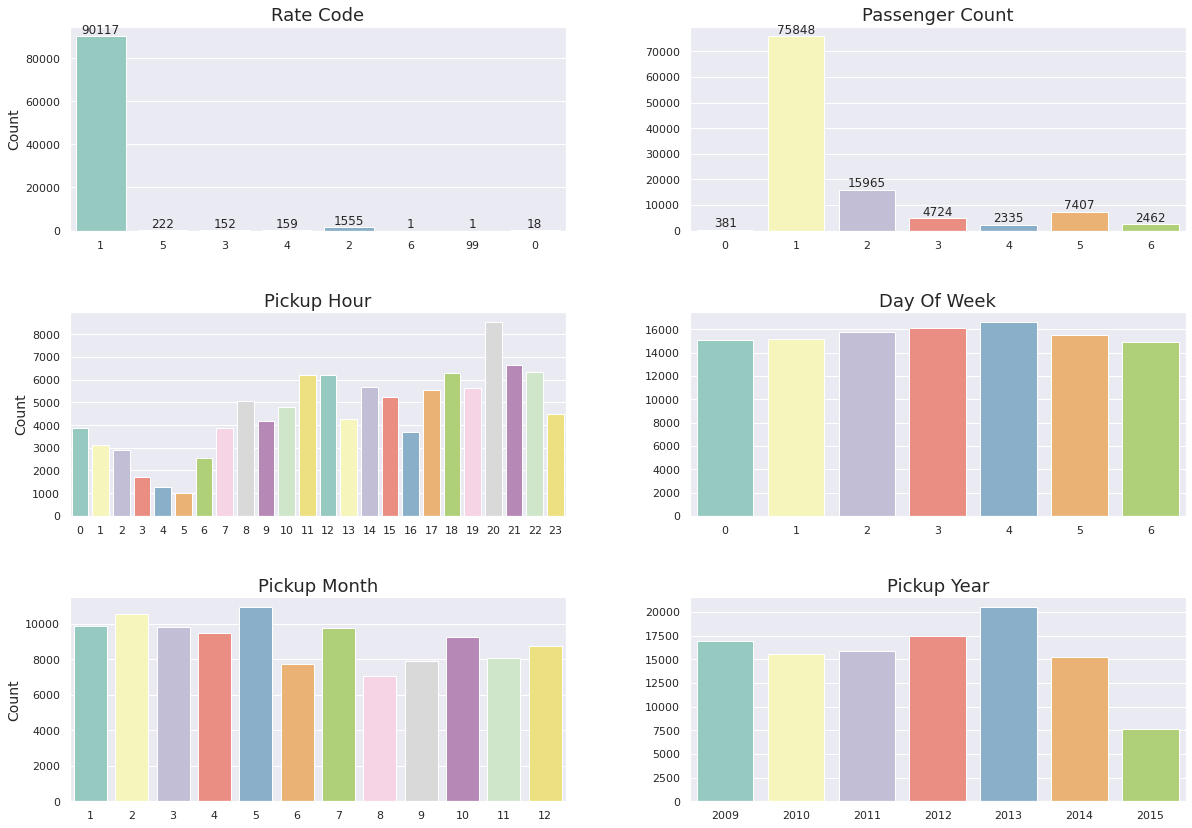

In [32]:
plt.figure(figsize=(20, 30))
for i, col in enumerate(["rate_code", "passenger_count", "pickup_hour", 
                         "day_of_week", "pickup_month", "pickup_year"], 1):
    plt.subplot(6, 2, i)
    ax = sns.countplot(x=col, data=nyc_trips, palette="Set3")
    
    # Annotate the rate code and passenger counts
    if col in ["rate_code", "passenger_count"]:
        ax.bar_label(ax.containers[0])
    
    plt.xlabel("")
    plt.ylabel("Count", size=14) if i%2 == 1 else plt.ylabel("")
    plt.title(f"{' '.join(col.split('_')).title()}", size=18)
    
plt.subplots_adjust(hspace=0.4, wspace=0.25);

In [7]:
print(f"Most recent pickup date: {nyc_trips['pickup_time'].max()}\n")

Most recent pickup date: 2015-06-30 23:57:04+00:00



Some takeaways from above plot:

- Over 80% of the trips use standard rate (1). (2) and (3) refers to JFK and Newark, respectively. Although surprisingly low airport counts, we can keep them. Rate code (6), group ride, can be excluded since the same information is mapped in the `passenger_count` column. As identified before, there are over 15,000 rows missing in this column. Although there are several ways we can approach this, we will go with the easiest solution which is excluding rows with missing values. We include rate codes 1–5 only.
- 70% of the trips have only one passenger while there are trips with zero passengers. It's unreasonable to charge for trips with no passengers and we'll therefore exclude those trips. Additionally, we can limit the variable to a maximum of 6 passengers to be on the safe side.
- The busies pickup hours are in the late afternoon throughout late evening. However, it's fairly consistent between 11:00 and 22:59 with some occasional dips around 13 and 16. The least busy hours are early mornings from 03:00 to 05:59. This seem reasonable and maps well with working hours. 
- The busiest days of the week are Thursdays and Fridays. But it's fairly consistent with little more than 10% difference between Sunday lows and Friday peaks. 
- *Averaged over all years*, May, July and October seem to be the busiest months, while June and August are least busy. This seem to hold true even if we additionally split it up by month as shown below.
- Most trips are registered during 2013 while fewest in 2015. However, as displayed more clearly below, 2015 contain only trips during the first six months of the year (light green bar).


Plot the number of trips by year and month.  

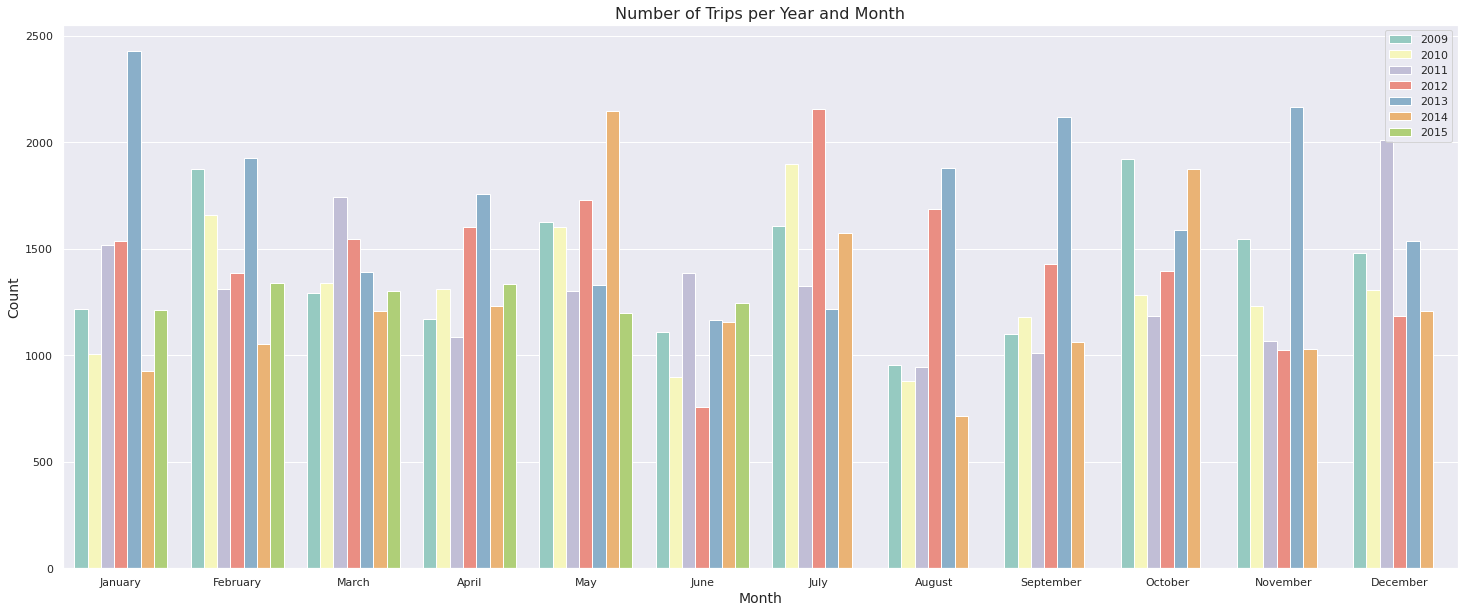

In [139]:
plt.figure(figsize=(25, 10))
ax = sns.countplot(x='pickup_month', data=nyc_trips, hue='pickup_year', palette="Set3")
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", 
                    "July", "August", "September", "October", "November", "December"])
plt.xlabel("Month", size=14)
plt.ylabel("Count", size=14)
plt.title("Number of Trips per Year and Month", size=16)
plt.legend(loc="upper right");

<a name="continuous"></a>

### [Continuous Variables](#top)

Next up, we will take a closer look at the continuous variables by plotting them using histograms.

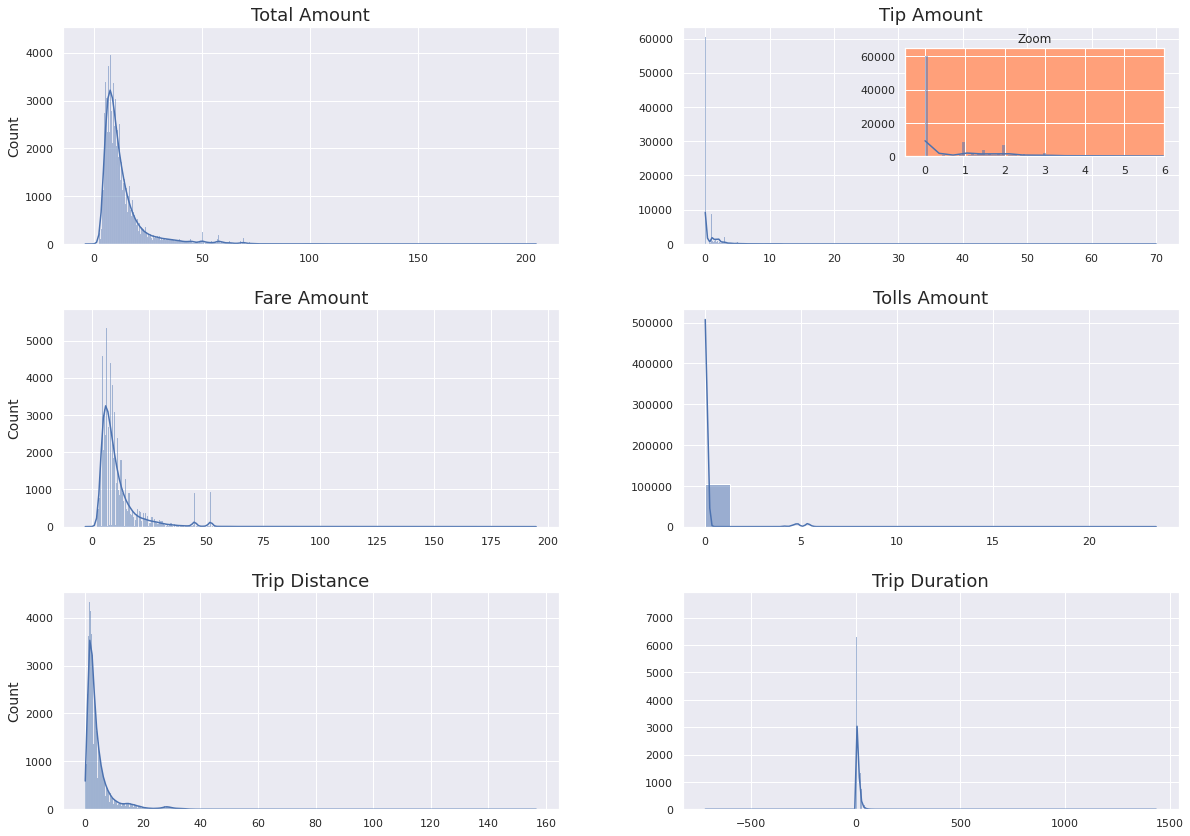

In [74]:
plt.figure(figsize=(20, 30))
for i, col in enumerate(["total_amount", "tip_amount", "fare_amount", 
                         "tolls_amount", "trip_distance", "trip_duration"], 1):
    plt.subplot(6, 2, i)
    ax = sns.histplot(x=col, data=nyc_trips, kde=True)
    plt.xlabel("")
    plt.ylabel("Count", size=14) if i%2 == 1 else plt.ylabel("")
    plt.title(f"{' '.join(col.split('_')).title()}", size=18)
    
# Zoom in on tip amount
ax2 = plt.axes([0.71, 0.82, .18, .05], facecolor='lightsalmon')
sns.histplot(x="tip_amount", data=nyc_trips, ax=ax2, kde=True)
ax2.set_title("Zoom")
ax2.set_xlim([-.5, 6])
ax2.set_ylim([0, 65000])
plt.xlabel("")
plt.ylabel("")

plt.subplots_adjust(hspace=0.3, wspace=0.25)
plt.show();

Take a closer look on tip above \\$3. 

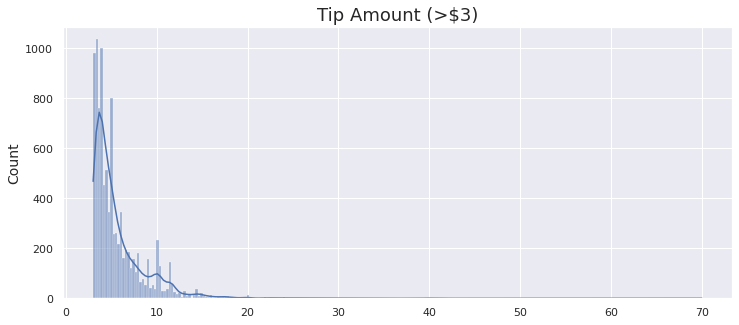

In [163]:
plt.figure(figsize=(12, 5))
col = 'tip_amount'
dd = nyc_trips[nyc_trips[col] > 3]
ax = sns.histplot(x=col, data=dd, kde=True)
plt.xlabel("")
plt.ylabel("Count", size=14)
plt.title("Tip Amount (>$3)", size=18);

We identify quite a lot of different tip amount above \\$3, but very few above \$15. 

In [76]:
print(f"Zero distance trips:                       {nyc_trips[nyc_trips['trip_distance'] <= 0].shape[0]}")
print(f"Trips with zero tolls amount:              {nyc_trips[nyc_trips['tolls_amount'] == 0].shape[0]}")
print(f"Trips with zero or negative total amount:  {nyc_trips[nyc_trips['total_amount'] <= 0].shape[0]}")
print(f"Trips with zero or negative trip duration: {nyc_trips[nyc_trips['trip_duration'] <= 0].shape[0]}")

Zero distance trips:                       749
Trips with zero tolls amount:              104657
Trips with zero or negative total amount:  2
Trips with zero or negative trip duration: 521


In [171]:
# Long trips but low total amount
nyc_trips[(nyc_trips["trip_distance"] > 100) & (nyc_trips["total_amount"] < 10)]

,total_amount,tip_amount,fare_amount,tolls_amount,pickup_time,dropoff_time,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,rate_code,passenger_count,pickup_hour,day_of_week,pickup_month,pickup_year,trip_duration
13212,3.50,0.00,2.5,0.0,2011-06-27 03:32:48+00:00,2011-06-27 04:01:00+00:00,-73.985094,40.759633,-73.962644,40.675460,122.15,1,1,3,0,6,2011,28.0
13624,3.00,0.00,2.5,0.0,2012-11-18 10:05:02+00:00,2012-11-18 10:26:09+00:00,-73.864025,40.770046,-73.960311,40.762222,156.59,1,1,10,6,11,2012,21.0
83134,9.12,1.52,6.1,0.0,2011-04-27 18:52:44+00:00,2011-04-27 18:59:16+00:00,-73.994292,40.741086,-73.989967,40.729657,131.00,1,1,18,2,4,2011,7.0


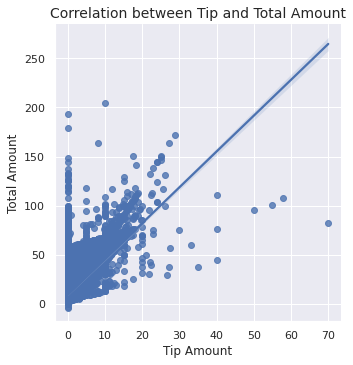

In [11]:
# Display the correlation between tip and total amount
sns.lmplot(data=nyc_trips, x="tip_amount", y="total_amount")
plt.title("Correlation between Tip and Total Amount", size=14)
plt.xlabel("Tip Amount", size=12)
plt.ylabel("Total Amount", size=12);

There is a strong positive correlation between tip amount and total amount. 

In [183]:
# Display trips that took more than 3 hours
nyc_trips.loc[nyc_trips["trip_duration"] > 180, ~nyc_trips.columns.isin(['pickup_time', 'dropoff_time'])]

,total_amount,tip_amount,fare_amount,tolls_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,rate_code,passenger_count,pickup_hour,day_of_week,pickup_month,pickup_year,trip_duration
1308,35.75,7.15,28.1,0.0,-74.007962,40.711660,-73.862102,40.767969,18.51,1,1,20,1,6,2011,753.0
8451,3.00,0.00,2.5,0.0,0.000000,0.000000,-73.964048,40.807668,0.00,1,1,20,3,2,2010,226.0
23385,5.50,0.00,4.5,0.0,-74.008171,40.723189,-74.001189,40.731016,1.29,1,1,23,2,6,2010,211.0
35346,7.30,0.00,6.5,0.0,-73.994034,40.751221,-74.001640,40.755661,0.92,1,1,15,6,4,2015,1436.0
55098,14.00,1.70,11.0,0.0,-73.968727,40.761581,-73.996689,40.761059,3.19,1,1,23,4,4,2015,1394.0
56777,12.30,0.00,11.5,0.0,-74.004181,40.721928,-73.991478,40.749722,3.89,1,1,7,3,3,2015,1429.0
57628,14.80,1.50,12.0,0.0,-73.978897,40.777279,-73.974075,40.748955,4.51,1,1,19,6,4,2015,1394.0
66362,57.30,0.00,52.0,4.8,-73.781945,40.644669,-73.999258,40.742303,28.81,2,1,17,2,11,2012,201.0
70014,6.00,0.70,5.3,0.0,0.000000,0.000000,0.000000,0.000000,1.75,None,2,12,1,1,2009,484.0


Among other things, we learn the following from above plots:


- `total_amount` includes negative values, which is rather counterintuitive. See below for how we approach this.
- Around 55% of the trips have zero tip. $1 and $2 tip amounts are the most common when tip is given. However, due to its nature of being a decision made by the rider, we will exclude this column and calculate `total_amount` as `fare_amount` + `tolls_amount`.
- There are negative values in `fare_amount`. We exclude all values that are zero or lower and set the upper threshold at $500. 
- Most trips (96%) don't include tolls. We can limit `tolls_amount` to the range [0, 25].
- Some long trips (>100km) have unreasonable low total fare amount (<$10) with questionable trip duration. Let's exclude those. We can also set a restriction to only include trips below 160km to assure we stay within the city area.
- There are many trips that have zero or negative `trip_duration` (521 in total), while others are taking very long time. Some are as long as almost 24 hours. I'm displaying trips that take more than 3 hours (180 min) below. Most of them are shorter than 5km. Perhaps they got stuck in traffic, but it's doubtful whether anyone would be stuck for nearly 24 hours. Although it's not unreasonable for taxi rides to take many hours (perhaps someone took one to Chicago), we will focus on trips in the closer vicinity of NY City and will thus exclude these data points. We'll specify the acceptable range to [0, 180].



<a name="correlation"></a>

### [Correlation between Features and Total Trip Amount](#top)

To better understand the relationship between the target variable and the features in the dataset, we will calculate Pearson correlation among the columns and display the result in something referred to as a correlation matrix.

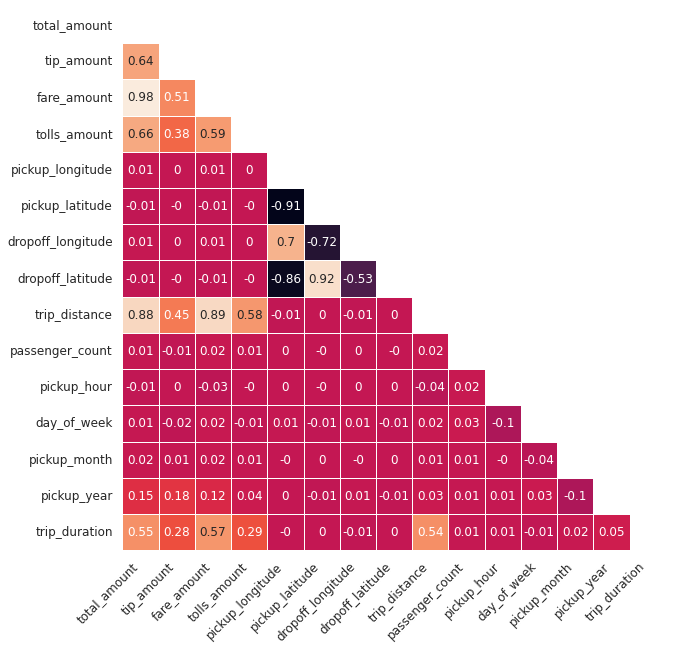

In [186]:
# Calculate correlation matrix
corr = nyc_trips.corr()

# Create mask to remove the mirrored diagonal of the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot correlation matrix
plt.figure(figsize=(10, 10))
with sns.axes_style("white"):
    sns.heatmap(np.round(corr, 2),  square=True,  annot=True,  
                cbar=False,  linewidth=.5, mask=mask)
    
#plt.title("Correlation Matrix", size=16)
plt.xticks(size=12, rotation=45, horizontalalignment='right')
plt.yticks(size=12);

- We note that `total_amount` is highly correlated with `fare_amount`, `trip_distance`, `tolls_amount`, `tip_amount` and `trip_duration`. This seems reasonable as we would expect longer trips, both in time and distance, to cost more. 
- There is a weak correlation with `pickup_year`. This also seems fairly reasonable as we can expect fares to change slightly over time. 
- The correlation is negligible for most other features such as pickup and drop-off coordinates. In isolation, this is reasonable. However, when combining longitude and latitude to form the exact pickup and drop-off locations we would expect this to affect the total fare. Above correlation matrix is unable to calculate pairwise correlations though and we would have to engineer this relationship ourselves. We will do this [in a later step](#model_4). Depending on how the taxi company sets its pricing, we would perhaps also expect `pickup_hour` to affect the fare amount more (rides might be more expensive during peak hours for example).



<a name="map"></a>

### [Display Pickup and Dropoff Locations on a Map](#top)

Plot the pickup and drop-off locations over a map of NY City to get a better understanding of their location. [This](https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration/notebook) Kaggle notebook has been a great source of inspiration. 

In [78]:
def plot_map(data, display_lines=True):
    # Specify figure size, background map and boundary box
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    nyc_map = plt.imread("images/NYC-map.png")
    boundary = (-74.75, -73, 40.2, 41.5)

    # Plot pickup locations
    axs[0].scatter(x=data["pickup_longitude"], 
                      y=data["pickup_latitude"], 
                      zorder=1)
    axs[0].imshow(nyc_map, zorder=0, extent=boundary)
    axs[0].set_xlim(boundary[:2])
    axs[0].set_ylim(boundary[2:])
    if display_lines:
        axs[0].axhline(y=40.55, linestyle = '-')
        axs[0].axvline(x=-73.9, linestyle = '-')
        axs[0].axvspan(-73.9, -73, 0, 0.27, alpha=0.2)
    axs[0].grid(None)
    axs[0].set_title("Pickup locations", size=16)

    # Plot dropoff locations
    axs[1].scatter(x=data["dropoff_longitude"], 
                          y=data["dropoff_latitude"], 
                          zorder=1, color="r", marker='^')
    axs[1].imshow(nyc_map, zorder=0, extent=boundary)
    axs[1].set_xlim(boundary[:2])
    axs[1].set_ylim(boundary[2:])
    if display_lines:
        axs[1].axhline(y=40.55, color="r", linestyle = '-')
        axs[1].axvline(x=-73.9, color="r", linestyle = '-')
        axs[1].axvspan(-73.9, -73, 0, 0.27, alpha=0.2, color='r')
    axs[1].grid(None)
    axs[1].set_title("Dropoff locations", size=16)
    plt.show();

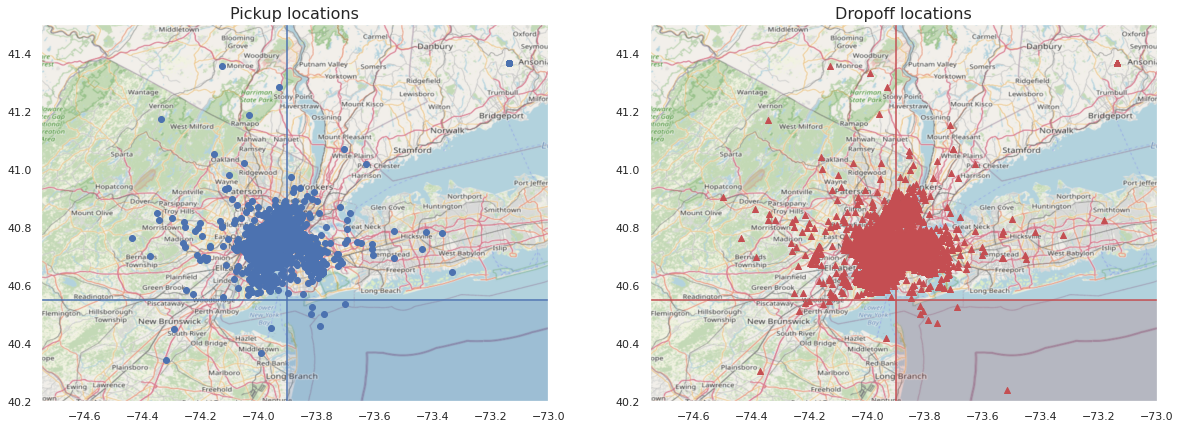

In [79]:
plot_map(nyc_trips)

We learn the following from above:


- We can confirm that most trips are concentrated within the city area. 
- However, there are also seemingly erroneous data points with pickup and/or drop-off locations in the ocean. One way to approach this is to exclude trips that are below latitude 40.55 while at the same time located east of longitude -73.9 (blue and red shaded areas). We can specify overall latitude limits to [40, 42] and longitudes to [-76, -73]. This also excludes some unreasonably high (pickup coordinates above 1,500) and low (pickup longitudes at -2,600 and 0) coordinates which were identified before.



<a name="query_constraints"></a>

### [Query the Data with above Constraints](#top)

Apply the constraints we've decided during the EDA and calculate the amount of excluded data.

In [184]:
%%bigquery nyc_trips_clean
SELECT
    (fare_amount + tolls_amount) AS total_amount,
    pickup_datetime AS pickup_time,
    dropoff_datetime AS dropoff_time,
    DATETIME_DIFF(dropoff_datetime, pickup_datetime, MINUTE) AS trip_duration,
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude,
    ROUND(trip_distance * 1.609344, 2) AS trip_distance, # Convert to km
    rate_code,
    passenger_count
FROM
    `nyc-tlc.yellow.trips`
WHERE
    ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 10000)) = 1
    AND fare_amount > 0 
    AND fare_amount <= 500
    AND tolls_amount BETWEEN 0 AND 25
    AND DATETIME_DIFF(dropoff_datetime, pickup_datetime, MINUTE) > 0
    AND DATETIME_DIFF(dropoff_datetime, pickup_datetime, MINUTE) <= 180
    AND NOT (pickup_latitude < 40.55 AND pickup_longitude > -73.9)
    AND NOT (dropoff_latitude < 40.55 AND dropoff_longitude > -73.9)
    AND (pickup_longitude BETWEEN -76 AND -73)
    AND (dropoff_longitude BETWEEN -76 AND -73)
    AND (pickup_latitude BETWEEN 40 AND 42)
    AND (dropoff_latitude BETWEEN 40 AND 42)
    AND passenger_count BETWEEN 1 AND 6
    AND trip_distance > 0
    AND ROUND(trip_distance * 1.609344, 2) < 160
    AND rate_code IN ('1', '2', '3', '4', '5')
    AND passenger_count BETWEEN 1 AND 6
ORDER BY pickup_time ASC;

Downloading: 100%|██████████| 89167/89167 [00:02<00:00, 31002.33rows/s]


In [185]:
display(nyc_trips_clean.head())
nyc_trips_clean.describe(exclude=["datetime64[ns, UTC]"])

,total_amount,pickup_time,dropoff_time,trip_duration,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,rate_code,passenger_count
0,6.5,2010-01-01 00:40:58+00:00,2010-01-01 00:47:44+00:00,6,-73.993304,40.747258,-73.993303,40.730909,2.41,1,1
1,13.3,2010-01-01 00:51:40+00:00,2010-01-01 01:31:03+00:00,39,-73.956125,40.779780,-73.978147,40.751322,7.08,1,1
2,7.3,2010-01-01 00:51:40+00:00,2010-01-01 01:00:55+00:00,9,-73.986113,40.746567,-73.993880,40.761935,2.90,1,1
3,5.3,2010-01-01 00:51:40+00:00,2010-01-01 00:57:53+00:00,6,-73.981838,40.740773,-73.992612,40.741159,1.29,1,4
4,9.3,2010-01-01 00:51:40+00:00,2010-01-01 01:01:31+00:00,9,-73.987877,40.725630,-73.958714,40.760935,4.83,1,2


,total_amount,trip_duration,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,rate_code,passenger_count
count,89167.000000,89167.000000,89167.000000,89167.000000,89167.000000,89167.000000,89167.000000,89167,89167.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87353,NaN
mean,11.565982,12.362488,-73.975532,40.750966,-73.974803,40.751261,4.650267,NaN,1.687407
std,9.758047,9.383091,0.036030,0.028003,0.036096,0.031855,5.436169,NaN,1.317258
min,2.500000,1.000000,-75.005102,40.342927,-75.013740,40.303943,0.020000,NaN,1.000000
25%,6.100000,6.000000,-73.992437,40.736578,-73.991776,40.735397,1.710000,NaN,1.000000
50%,8.500000,10.000000,-73.982147,40.753292,-73.980805,40.753840,2.900000,NaN,1.000000
75%,13.000000,16.000000,-73.968598,40.767619,-73.965653,40.768375,5.150000,NaN,2.000000


In [23]:
old = nyc_trips.shape[0]
new = nyc_trips_clean.shape[0]
rate = sum(nyc_trips['rate_code'].isna())

print(f"Percent of original dataset remaining: {new/old:.0%} ({1-new/old:.0%} excluded)")
print(f"Out of the {1-new/old:.0%}, {rate/old:.0%} is a result of missing values in column 'rate_code'\n")

Percent of original dataset remaining: 82% (18% excluded)
Out of the 18%, 15% is a result of missing values in column 'rate_code'



Average total fare amount is \\$11.6, with a standard deviation of \$9.8.

As pointed out before, `rate_code` contributes significantly to the data loss. Out of the 18% that's excluded, 15% is a result of `Null`s in this column.

<a name="BigQueryML"></a>

## [Machine Learning with BigQuery ML](#top)

Now comes the most exciting part; applying machine learning to make predictions on the total fare amount. To save on development costs and to speed things up, we will approach this as before; starting out with a smaller dataset for experimentation, and once a satisfying result is achieved, we train a model on the entire dataset. Although much of it can be completely automated in BigQuery, we will take it step by step as it will be easier to follow along.

BigQuery makes it easy to apply a variety of [different models](https://cloud.google.com/bigquery-ml/docs/introduction#supported_models_in) on the data. Although it's best practice to experiment with several different models, for the purpose of this article, we will go with Linear Regression only. Even though there are differences in data preparation and hyperparameters between the models, the general steps are common. Linear Regression is fast to train but requires more work in order to map the interrelationship between features for best performance. We will cover this in more depth in the [Model 4: Feature Engineering](#model_4) section below.


We can set the baseline to beat at \\$9.8, which is equivalent to the standard deviation. However, we want to be a little more ambitious than that and set our goal to below \$3. 

> **Goal: Below \$3**

<a name="data_table_small"></a>

### [Create a Data Table for ML and Exclude Irrelevant Values](#top)

Based on what we've learned from the exploratory data analysis earlier, we can now go ahead and create a training data table. We will also make sure to order the data by `dropoff_time`. This way we'll be making predictions on future trips which is more similar to a real-world setting. There's also the risk of trips on the same day being correlated due to traffic conditions and so forth. Ordering by date might help to mitigate this. The query for creating a data table using the constraints we decided during the EDA while keeping the data size as before looks as follows:


In [62]:
%%bigquery

CREATE OR REPLACE TABLE
    nyc_taxi_cabs.taxi_data AS
SELECT
    (fare_amount + tolls_amount) AS total_amount,
    pickup_datetime AS pickup_time,
    dropoff_datetime AS dropoff_time,
    DATETIME_DIFF(dropoff_datetime, pickup_datetime, MINUTE) AS trip_duration,
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude,
    ROUND(trip_distance * 1.609344, 2) AS trip_distance, # Convert to km
    rate_code,
    passenger_count
FROM
    `nyc-tlc.yellow.trips`
WHERE
    ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 10000)) = 1
    AND fare_amount > 0 
    AND fare_amount <= 500
    AND tolls_amount BETWEEN 0 AND 25
    AND DATETIME_DIFF(dropoff_datetime, pickup_datetime, MINUTE) > 0
    AND DATETIME_DIFF(dropoff_datetime, pickup_datetime, MINUTE) <= 180
    AND NOT (pickup_latitude < 40.55 AND pickup_longitude > -73.9)
    AND NOT (dropoff_latitude < 40.55 AND dropoff_longitude > -73.9)
    AND (pickup_longitude BETWEEN -76 AND -73)
    AND (dropoff_longitude BETWEEN -76 AND -73)
    AND (pickup_latitude BETWEEN 40 AND 42)
    AND (dropoff_latitude BETWEEN 40 AND 42)
    AND passenger_count BETWEEN 1 AND 6
    AND trip_distance > 0
    AND ROUND(trip_distance * 1.609344, 2) < 160
    AND rate_code IN ('1', '2', '3', '4', '5')
    AND passenger_count BETWEEN 1 AND 6
ORDER BY dropoff_time ASC;

Query complete after 0.00s: 100%|██████████| 2/2 [00:00<00:00, 1115.95query/s]                        


""



<a name="model_1"></a>


### [Model 1: Three Features only](#top)

We will start out humbly by only including three features:

- `trip_distance`
- `rate_code`
- `passenger_count`

Target variable (what we want to predict) is the total trip amount, `total_amount` while we will be using `dropoff_time` to split the data sequentially to maintain trip date ordering. BigQuery splits the data for us automatically into train and evaluation sets so we don't have to worry about that.

In [4]:
%%bigquery

CREATE OR REPLACE MODEL
    nyc_taxi_cabs.model_1 OPTIONS (model_type='linear_reg', 
                                   input_label_cols=['total_amount'],
                                   data_split_method="SEQ",
                                   data_split_col="dropoff_time") AS
SELECT
    total_amount,
    dropoff_time,
    trip_distance,
    rate_code,
    passenger_count
FROM
    nyc_taxi_cabs.taxi_data;

Query complete after 0.01s: 100%|██████████| 3/3 [00:00<00:00, 1589.15query/s]                        


""


#### Evaluate the First Model

We use the following SQL to evaluate the model on the train set.

In [64]:
%%bigquery

SELECT 
    *, 
    SQRT(loss) AS train_rmse
FROM
    ML.TRAINING_INFO(MODEL nyc_taxi_cabs.model_1)

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.13s/rows]


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,train_rmse
0,0,0,10.618441,11.182996,NaN,3863,3.258595


And the following to evaluate it on the test set.

In [65]:
%%bigquery

SELECT 
    *, 
    SQRT(mean_squared_error) AS eval_rmse
FROM
    ML.EVALUATE(MODEL nyc_taxi_cabs.model_1)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.91s/rows]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance,eval_rmse
0,2.026646,11.182996,0.038098,1.132291,0.906943,0.923225,3.344099


We get an RMSE of 3.34 on the test set and 3.26 on the train set on the first attempt- significantly better than the 9.8 baseline and pretty close to the goal of 3.0! BigQuery also provides us with other evaluation metrics by default and with the possibility of complete customisation. However, RMSE has the advantage of providing the error in the unit being measured (which is USD in this case) and is thus easier for the human eye to interpret.


<a name="model_2"></a>

### [Model 2: Include another Five Features](#top)

For model 2, we include the following fetaures:

- `trip_distance`
- `rate_code`
- `passenger_count`
- `trip_duration`
- `pickup_longitude`
- `pickup_latitude`
- `dropoff_longitude`
- `dropoff_latitude`


In [67]:
%%bigquery

CREATE OR REPLACE MODEL
    nyc_taxi_cabs.model_2 OPTIONS (model_type='linear_reg', 
                                   input_label_cols=['total_amount'],
                                   data_split_method="SEQ",
                                   data_split_col="dropoff_time") AS
SELECT
    total_amount,
    dropoff_time,
    trip_distance,
    rate_code,
    passenger_count,
    trip_duration,
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude,
FROM
    nyc_taxi_cabs.taxi_data;

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1913.46query/s]                        


""


#### Evalute the Second Model

In [68]:
%%bigquery

SELECT 
    *, 
    SQRT(loss) AS train_rmse
FROM
    ML.TRAINING_INFO(MODEL nyc_taxi_cabs.model_2)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.97s/rows]


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,train_rmse
0,0,0,6.738584,5.905716,NaN,5408,2.595878


In [69]:
%%bigquery

SELECT 
    *, 
    SQRT(mean_squared_error) AS eval_rmse
FROM
    ML.EVALUATE(MODEL nyc_taxi_cabs.model_2)

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.15s/rows]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance,eval_rmse
0,1.282252,5.905716,0.010774,0.709014,0.950871,0.961681,2.430168


Adding an additional five features boosted the RMSE on the evaluation set to 2.43 as compared to previous 3.34. 

<a name="model_3"></a>

### [Model 3: Include Datetime Features](#top)

Extract hour, weekday, month and year from the `pickup_datetime` column. 

Unlike when we extracted weekday with Pandas, where the week started with Monday, BigQuery's `DAYOFWEEK` assumes Sunday to be the start of the week. However, for the purpose of this analysis, it shouldn't make a difference.

In [70]:
%%bigquery

CREATE OR REPLACE MODEL
    nyc_taxi_cabs.model_3 OPTIONS (model_type='linear_reg', 
                                   input_label_cols=['total_amount'],
                                   data_split_method="SEQ",
                                   data_split_col="dropoff_time") AS
SELECT
    total_amount,
    dropoff_time,
    trip_distance,
    rate_code,
    passenger_count,
    trip_duration,
    EXTRACT(HOUR FROM pickup_time) AS pickup_hour,
    EXTRACT(DAYOFWEEK FROM pickup_time) AS pickup_day,
    EXTRACT(MONTH FROM pickup_time) AS pickup_month,
    EXTRACT(YEAR FROM pickup_time) AS pickup_year,
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude,
FROM
    nyc_taxi_cabs.taxi_data;

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1821.76query/s]                        


""


#### Evaluate the Third Model



In [71]:
%%bigquery

SELECT 
    *, 
    SQRT(loss) AS train_rmse
FROM
    ML.TRAINING_INFO(MODEL nyc_taxi_cabs.model_3)

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.02s/rows]


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,train_rmse
0,0,0,6.120597,4.96444,NaN,6451,2.473984


In [72]:
%%bigquery

SELECT 
    *, 
    SQRT(mean_squared_error) AS eval_rmse
FROM
    ML.EVALUATE(MODEL nyc_taxi_cabs.model_3)

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.19s/rows]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance,eval_rmse
0,1.378041,4.96444,0.021198,1.108278,0.958697,0.961115,2.228102


2.47 RMSE on the train set and 2.23 on the evaluation set.

<a name="model_4"></a>

### [Model 4: Feature Engineering](#top)

Engineer new features by combining two or more current features into new ones. The idea is to better map the information within the data so that the model can better learn from it. However, this comes with an additional risk of overfitting and subsequent model performance decline if not addressed.


- `euclidean`: Calculate the shortest distance between two points on the map.
- `day_hour`: A combination of weekday and hour to map the hour in the week. Mornings during the week might have other characteristics, such as being busier, than mornings during the weekend, for example.
- `month_hour`: A combination of month and hour to map the hour in a month for the trip. 


This leads us to the following query for model 4:

In [91]:
%%bigquery

CREATE OR REPLACE MODEL
    nyc_taxi_cabs.model_4 OPTIONS (model_type='linear_reg',
                                   input_label_cols=['total_amount'],
                                   data_split_method="SEQ",
                                   data_split_col="dropoff_time") AS
SELECT
    total_amount,
    dropoff_time,
    trip_distance,
    ROUND(ST_DISTANCE(ST_GEOGPOINT(pickup_longitude, pickup_latitude),
                      ST_GEOGPOINT(dropoff_longitude, dropoff_latitude)), 0) AS euclidean,
    rate_code,
    passenger_count,
    trip_duration,
    EXTRACT(HOUR FROM pickup_time) AS pickup_hour,
    EXTRACT(DAYOFWEEK FROM pickup_time) AS pickup_day,
    EXTRACT(MONTH FROM pickup_time) AS pickup_month,
    EXTRACT(YEAR FROM pickup_time) AS pickup_year,
    ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_time) AS STRING) AS pickup_day, 
                            CAST(EXTRACT(HOUR FROM pickup_time) AS STRING) AS pickup_hour)) AS day_hour,
    ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(MONTH FROM pickup_time) AS STRING) AS pickup_month, 
                        CAST(EXTRACT(HOUR FROM pickup_time) AS STRING) AS pickup_hour)) AS month_hour,
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude,
FROM
    nyc_taxi_cabs.taxi_data;

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1529.47query/s]                        


""


#### Evaluate the Fourth Model


In [92]:
%%bigquery

SELECT 
    *, 
    SQRT(loss) AS train_rmse
FROM
    ML.TRAINING_INFO(MODEL nyc_taxi_cabs.model_4)

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.06s/rows]


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,train_rmse
0,0,0,5.645111,5.167854,NaN,8755,2.375944


In [93]:
%%bigquery

SELECT 
    *, 
    SQRT(mean_squared_error) AS eval_rmse
FROM
    ML.EVALUATE(MODEL nyc_taxi_cabs.model_4)

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.09s/rows]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance,eval_rmse
0,1.375786,5.167854,0.020874,1.065425,0.956984,0.959059,2.273291


The additional features allow the model to fit the data a little better, yielding an RMSE of 2.27 on the test set and 2.38 on the train set.


<a name="model_5"></a>

### [Model 5: Add Regularisation and Tune Model](#top)



Although the model is not overfitting much, we can experiment with regularisation to see if we can push the test RMSE closer to the train RMSE. It's a common approach and there are two main ways to do that with Linear Regression; L1 and L2. We won't go into the details of how they work other than mentioning that L1 decreases (and even removes) the importance of the least important features, while L2 shrinks the importance of all features. The degree to how much this is done can be tuned and is specific for each use case and dataset. 

For the purpose of this blog post we will focus on L1 and experiment with values `[0, 0.1, 1, 10]`. Executing it in parallel will speed things up. BigQuery splits the data into `80:10:10` train-evaluate-test sets by default during hyperparameter tuning and we won't interfere with that. The model is trained on the train set before evaluated on the evaluation set during each one of the four runs (four because we will evaluate four values of L1). Lastly, the final model performance is calculated by testing it on the test set which the model hasn't seen before. All this is done automatically by BigQuery. 

By wrapping the features within the `TRANSFORM` clause we ensure that the same pre-processing steps taken during training are applied during evaluation and model deployment.


In [96]:
%%bigquery

CREATE OR REPLACE MODEL nyc_taxi_cabs.model_5
    TRANSFORM( 
        total_amount,
        dropoff_time,
        trip_distance,
        ROUND(ST_DISTANCE(ST_GEOGPOINT(pickup_longitude, pickup_latitude),
                        ST_GEOGPOINT(dropoff_longitude, dropoff_latitude)), 0) AS euclidean,
        rate_code,
        passenger_count,
        trip_duration,
        EXTRACT(HOUR FROM pickup_time) AS pickup_hour,
        EXTRACT(DAYOFWEEK FROM pickup_time) AS pickup_day,
        EXTRACT(MONTH FROM pickup_time) AS pickup_month,
        EXTRACT(YEAR FROM pickup_time) AS pickup_year,
        ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_time) AS STRING) AS pickup_day, 
                                CAST(EXTRACT(HOUR FROM pickup_time) AS STRING) AS pickup_hour)) AS day_hour,
        ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(MONTH FROM pickup_time) AS STRING) AS pickup_month, 
                            CAST(EXTRACT(HOUR FROM pickup_time) AS STRING) AS pickup_hour)) AS month_hour,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude)
        OPTIONS (model_type='linear_reg', 
                 input_label_cols=['total_amount'],
                 data_split_method="SEQ",
                 data_split_col="dropoff_time",
                 num_trials=4,
                 max_parallel_trials=4,
                 l1_reg=hparam_candidates([0, 0.1, 1, 10]),
                 hparam_tuning_objectives=["mean_squared_error"]) AS
SELECT
    *
FROM
    nyc_taxi_cabs.taxi_data;

Query complete after 0.01s: 100%|██████████| 9/9 [00:00<00:00, 1667.57query/s]                        


""


#### Evaluate the Fifth Model



In [1]:
%%bigquery

SELECT *,
    SQRT(training_loss) AS train_rmse,
    SQRT(eval_loss) AS eval_rmse
FROM
    ML.TRIAL_INFO(MODEL nyc_taxi_cabs.model_5)

Downloading: 100%|██████████| 4/4 [00:02<00:00,  1.93rows/s]


,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal,train_rmse,eval_rmse
0,1,{'l1_reg': 1.0},{'mean_squared_error': 5.5847208322334865},5.977335,5.584721,SUCCEEDED,None,False,2.444859,2.363201
1,2,{'l1_reg': 0.0},{'mean_squared_error': 4.930308169445975},5.644025,4.930308,SUCCEEDED,None,True,2.375716,2.220430
2,3,{'l1_reg': 0.1},{'mean_squared_error': 5.586751974676974},5.977533,5.586752,SUCCEEDED,None,False,2.444899,2.363631
3,4,{'l1_reg': 10.0},{'mean_squared_error': 5.568113598640613},5.976581,5.568114,SUCCEEDED,None,False,2.444705,2.359685


In [98]:
%%bigquery

SELECT 
    *, 
    SQRT(mean_squared_error) AS test_rmse
FROM
    ML.EVALUATE(MODEL nyc_taxi_cabs.model_5)

Downloading: 100%|██████████| 4/4 [00:01<00:00,  2.07rows/s]


,trial_id,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance,test_rmse
0,1,1.391630,5.853383,0.019657,1.021583,0.953968,0.955486,2.419377
1,2,1.436687,5.411684,0.022244,1.156395,0.957441,0.960444,2.326303
2,3,1.393306,5.855770,0.019715,1.023533,0.953949,0.955488,2.419870
3,4,1.375318,5.831587,0.019089,1.000309,0.954139,0.955458,2.414868


No regularisation (`L1 = 0.0`) results in the best model with an RMSE on the test set of 2.33 and 2.22 on the evaluation set. Note that since the data has been split into three sets during the hyperparameter tuning process, rather than previously two, the results are not exactly the same as for model 4 even though the regularisation parameter hasn't changed.


<a name="all_data"></a>

## [Train on All the Data](#top)

We've found the most optimal set of hyperparameters, engineered extra features, saved both time and money on the small dataset and can now move forward by training on the full, 1 billion trips, dataset.


<a name="all_data_table"></a>

### [Create a Data Table using All the Data](#top)

To start, query the original dataset to create a new table including all the rows while still applying the same constraints as before.

In [102]:
%%bigquery

CREATE OR REPLACE TABLE
    nyc_taxi_cabs.taxi_data_all AS
SELECT
    (fare_amount + tolls_amount) AS total_amount,
    pickup_datetime AS pickup_time,
    dropoff_datetime AS dropoff_time,
    DATETIME_DIFF(dropoff_datetime, pickup_datetime, MINUTE) AS trip_duration,
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude,
    ROUND(trip_distance * 1.609344, 2) AS trip_distance, # Convert to km
    rate_code,
    passenger_count
FROM
    `nyc-tlc.yellow.trips`
WHERE
    fare_amount > 0 
    AND fare_amount <= 500
    AND tolls_amount BETWEEN 0 AND 25
    AND DATETIME_DIFF(dropoff_datetime, pickup_datetime, MINUTE) > 0
    AND DATETIME_DIFF(dropoff_datetime, pickup_datetime, MINUTE) <= 180
    AND NOT (pickup_latitude < 40.55 AND pickup_longitude > -73.9)
    AND NOT (dropoff_latitude < 40.55 AND dropoff_longitude > -73.9)
    AND (pickup_longitude BETWEEN -76 AND -73)
    AND (dropoff_longitude BETWEEN -76 AND -73)
    AND (pickup_latitude BETWEEN 40 AND 42)
    AND (dropoff_latitude BETWEEN 40 AND 42)
    AND passenger_count BETWEEN 1 AND 6
    AND trip_distance > 0
    AND ROUND(trip_distance * 1.609344, 2) < 160
    AND rate_code IN ('1', '2', '3', '4', '5')
    AND passenger_count BETWEEN 1 AND 6
ORDER BY dropoff_time ASC;

Query complete after 0.00s: 100%|██████████| 7/7 [00:00<00:00, 3663.15query/s]                        


""


Before initiating model training, verify that the columns are all within expected values.


In [103]:
%%bigquery

SELECT
    MIN(total_amount) AS min_total_amount,
    MAX(total_amount) AS max_total_amount,
    MIN(trip_duration) AS min_trip_duration,
    MAX(trip_duration) AS max_trip_duration,
    MIN(pickup_longitude) AS min_pickup_longitude,
    MAX(pickup_longitude) AS max_pickup_longitude,
    MIN(pickup_latitude) AS min_pickup_latitude,
    MAX(pickup_latitude) AS max_pickup_latitude,
    MIN(dropoff_longitude) AS min_dropoff_longitude,
    MAX(dropoff_longitude) AS max_dropoff_longitude,
    MIN(dropoff_latitude) AS min_dropoff_latitude,
    MAX(dropoff_latitude) AS max_dropoff_latitude,
    MIN(trip_distance) AS min_trip_distance,
    MAX(trip_distance) AS max_trip_distance,
    MIN(rate_code) AS min_rate_code,
    MAX(rate_code) AS max_rate_code,
    MIN(passenger_count) AS min_passenger_count,
    MAX(passenger_count) AS max_passenger_count

FROM `level-library-342009.nyc_taxi_cabs.taxi_data_full`;

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.28s/rows]


,min_total_amount,max_total_amount,min_trip_duration,max_trip_duration,min_pickup_longitude,max_pickup_longitude,min_pickup_latitude,max_pickup_latitude,min_dropoff_longitude,max_dropoff_longitude,min_dropoff_latitude,max_dropoff_latitude,min_trip_distance,max_trip_distance,min_rate_code,max_rate_code,min_passenger_count,max_passenger_count
0,0.01,515.75,1,180,-76.0,-73.0,40.0,42.0,-76.0,-73.0,40.0,42.0,0.02,159.97,1,5,1,6


We are pretty pleased with these insights and can now move forward with model training on the full data.


<a name="model_all"></a>

### [Train Model on All the Data](#top)

In [104]:
%%bigquery

CREATE OR REPLACE MODEL nyc_taxi_cabs.model_all
    TRANSFORM( 
        total_amount,
        dropoff_time,
        trip_distance,
        ROUND(ST_DISTANCE(ST_GEOGPOINT(pickup_longitude, pickup_latitude),
                        ST_GEOGPOINT(dropoff_longitude, dropoff_latitude)), 0) AS euclidean,
        rate_code,
        passenger_count,
        trip_duration,
        EXTRACT(HOUR FROM pickup_time) AS pickup_hour,
        EXTRACT(DAYOFWEEK FROM pickup_time) AS pickup_day,
        EXTRACT(MONTH FROM pickup_time) AS pickup_month,
        EXTRACT(YEAR FROM pickup_time) AS pickup_year,
        ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_time) AS STRING) AS pickup_day, 
                                CAST(EXTRACT(HOUR FROM pickup_time) AS STRING) AS pickup_hour)) AS day_hour,
        ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(MONTH FROM pickup_time) AS STRING) AS pickup_month, 
                            CAST(EXTRACT(HOUR FROM pickup_time) AS STRING) AS pickup_hour)) AS month_hour,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude)
        OPTIONS (model_type='linear_reg', 
                 input_label_cols=['total_amount'],
                 data_split_method="SEQ",
                 data_split_col="dropoff_time",
                 l1_reg=0.0) AS
SELECT
    *
FROM
    nyc_taxi_cabs.taxi_data_all;

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1599.66query/s]                        


""


Training took around 21 minutes at a price of less than 20 USD. 


#### Evaluate the Model

Evaluate the model on both the train and test sets. 

In [117]:
%%bigquery

SELECT 
    *, 
    SQRT(loss) AS train_rmse
FROM
    ML.TRAINING_INFO(MODEL nyc_taxi_cabs.model_all)

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.06s/rows]


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,train_rmse
0,0,0,5.552879,6.706402,NaN,115125,2.356455


In [118]:
%%bigquery

SELECT 
    *, 
    SQRT(mean_squared_error) AS test_rmse
FROM
    ML.EVALUATE(MODEL nyc_taxi_cabs.model_all)

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.24s/rows]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance,test_rmse
0,1.405486,6.706402,0.021994,1.088491,0.945919,0.947465,2.589672


We end up with a final RMSE on the train set of 2.36 and 2.59 on the test set. This is a little worse than what we achieved with model 5 which was trained on only 100k samples. There are some minor indications of overfitting (because the RMSE discrepancy between the train and test sets has increased) and perhaps adding regularisation when training on the full dataset would be beneficial after all. We won't iterate on that here other than pointing it out.



<a name="model_summary"></a>


## [RMSE Model Summary](#top)

A summary on the train and test sets of all the models we've trained is found below. The best performance is achieved with models 3 and 4, taking into account that they were only trained on a subset of the data. We note the slight increase in overfitting on the final model.

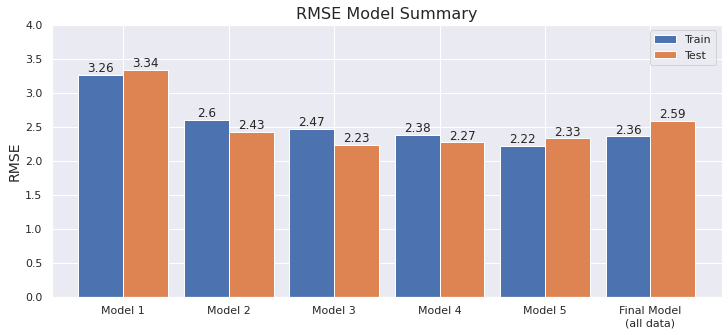

In [4]:
x = ['Model 1', 'Model 2', 'Model 3','Model 4', 'Model 5', 'Final Model\n(all data)']
RMSE_train = [3.26, 2.60, 2.47, 2.38, 2.22, 2.36]
RMSE_test = [3.34, 2.43, 2.23, 2.27, 2.33, 2.59]

summary = pd.DataFrame(index=x, data={'Train': RMSE_train,
                                      'Test': RMSE_test})

ax = summary.plot.bar(figsize=(12, 5), rot=0, width=.85)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set_ylim([0, 4])
#plt.xlabel("Model", size=14)
plt.ylabel("RMSE", size=14)
plt.title("RMSE Model Summary", size=16);



<a name="predictions"></a>

## [Model Prediction and Analysis](#top)

What purpose has a model if we don't use it to make predictions with? Query 1 million samples and use the model to make predictions on them. Also, calculate the prediction errors by taking the difference between the prediction and the true label. The query looks like this:

In [3]:
%%bigquery predictions

SELECT
    *,
    (predicted_total_amount - total_amount) AS prediction_error
FROM
  ML.PREDICT(MODEL nyc_taxi_cabs.model_all,
    (
    SELECT
      *
    FROM
      `nyc_taxi_cabs.taxi_data_all`
    LIMIT 1000000))

Downloading: 100%|██████████| 1000000/1000000 [00:04<00:00, 233244.77rows/s]


We can then display the prediction error distribution and perform some basic analysis on the model performance.

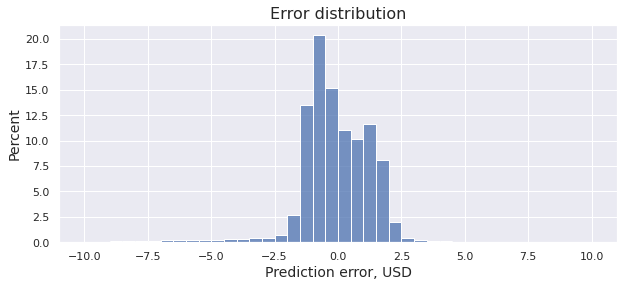

In [4]:
plt.figure(figsize=(10, 4))
ax = sns.histplot(x='prediction_error', data=predictions, stat='percent', discrete=False, bins=40, binrange=(-10, 10), element="bars")
plt.xlabel("Prediction error, USD", size=14)
plt.ylabel("Percent", size=14)
plt.title("Error distribution", size=16);

95% of the prediction errors are lower than ±2.5 USD, which is in line with the RMSE on the test set. However, there are some predictions that are off by more than \\$100 in both directions as displayed below. 

In [5]:
predictions['prediction_error'].describe()

count    1000000.000000
mean          -0.182288
std            2.565457
min         -321.446590
25%           -0.892768
50%           -0.220328
75%            0.901095
max          173.090452
Name: prediction_error, dtype: float64

In [37]:
# Display very high prediction errors (>±100)
bad_100 = predictions[(predictions['prediction_error'] > 100) | (predictions['prediction_error'] < -100)]
display(bad_100.head())
bad_100.describe()

,predicted_total_amount,total_amount,pickup_time,dropoff_time,trip_duration,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,rate_code,passenger_count,prediction_error
1219,107.982201,211.33,2015-06-25 12:06:06+00:00,2015-06-25 13:22:36+00:00,76,-73.864304,40.770432,-74.001518,41.047829,74.26,4,1,-103.347799
10087,173.553410,495.00,2015-06-25 14:33:00+00:00,2015-06-25 16:13:51+00:00,100,-74.632217,40.575100,-73.873489,40.774181,88.32,5,1,-321.446590
27411,173.110452,0.02,2015-06-25 20:12:33+00:00,2015-06-25 22:05:16+00:00,112,-73.806175,40.652275,-74.253464,40.714207,90.45,5,1,173.090452
31207,127.187632,230.00,2015-06-25 23:21:07+00:00,2015-06-26 00:03:56+00:00,42,-73.943253,40.778843,-73.490410,40.674911,60.48,5,1,-102.812368
33913,120.395020,9.01,2015-06-26 00:46:02+00:00,2015-06-26 02:01:55+00:00,75,-73.788818,40.642040,-74.041733,40.747128,49.73,5,3,111.385020


,predicted_total_amount,total_amount,trip_duration,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,passenger_count,prediction_error
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,59.741305,168.971212,28.939394,-74.009674,40.755248,-73.944288,40.795741,27.303636,1.212121,-109.229907
std,60.415141,103.890889,38.133761,0.191024,0.113564,0.300616,0.153004,36.183545,0.599874,102.134564
min,-0.139852,0.020000,1.000000,-74.632217,40.428747,-74.309631,40.420429,0.020000,1.000000,-321.446590
25%,5.282734,120.000000,2.000000,-74.155660,40.711359,-74.155660,40.727104,1.400000,1.000000,-136.311904
50%,46.240816,150.000000,7.000000,-73.986275,40.754959,-73.996735,40.754253,3.590000,1.000000,-117.764451
75%,107.982201,230.000000,48.000000,-73.943253,40.772686,-73.966995,40.778248,58.470000,1.000000,-103.347799
max,182.288956,495.000000,140.000000,-73.624175,41.028908,-73.071930,41.179123,97.250000,3.000000,173.090452


Let's take a closer look at some of the worse predictions with absolute errors above \\$100:


- *Trip #27411* (see above): This trip is labelled with a total trip amount of \\$0.02 despite taking almost 2 hours (112 min) at a distance of 90km. The data thus seem to be inaccurate in one way or another which would then explain the \\$173 prediction error. 
- *Trip #33913*: A very low total fare amount (\\$9) despite long in both duration and distance. We might have a data issue here as well. 
- *Trip #10087*: This is the trip with the largest (underestimated) error at -\\$321. The labelled total amount is \\$495. It might be an accurate data point since it's marked as a Negotiated fare (`rate_code` = 5), meaning that the driver and rider agreed on a fare. Perhaps the rider was in a hurry and also needed to make some errands along the way and was happy to pay a premium for this. However, both the trip distance and duration are very similar to that of trip #27411 so it's not unreasonable to think that they should have roughly the same price. Not 3 times more. The model certainly estimates along these lines as well. 

Negotiated fare is highly overrepresented with almost 30% of the trips (see the plot below) among trips with large errors. This is in large contrast to the general distribution of the dataset where negotiated fares make up only 0.2%. Perhaps negotiated fares are more random or have some other characteristics that makes them harder to predict. We should find ways of better mapping this if we want to improve model performance in the extremes.

There are thus several data points where we can question the validity of the data. Perhaps it's not the model that's doing bad but poor data that's behind the large prediction errors we experience on at least some of these trips.


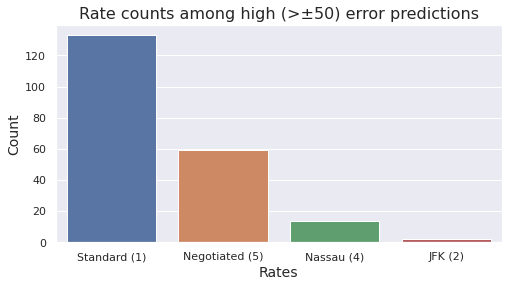

In [39]:
# Display rate counts for high prediction errors
bad_50 = predictions[(predictions['prediction_error'] > 50) | (predictions['prediction_error'] < -50)]

plt.figure(figsize=(8, 4))
ax = sns.countplot(x="rate_code", 
                   data=bad_50, 
                   order=bad_50['rate_code'].value_counts() \
                                               .index)
ax.set_xticklabels(["Standard (1)", "Negotiated (5)", "Nassau (4)", "JFK (2)"])
plt.xlabel("Rates", size=14)
plt.ylabel("Count", size=14)
plt.title("Rate counts among high (>±50) error predictions", size=16);

We can also verify that most trips take place within, or very close to New York and its vicinity by plotting them on a map. This way we can visually confirm that most of them are of shorter distance.

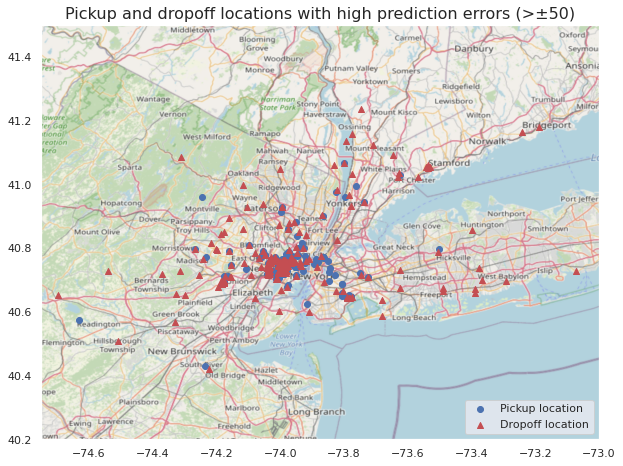

In [42]:
# Specify figure size, background map and boundary box
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
nyc_map = plt.imread("images/NYC-map.png")
boundary = (-74.75, -73, 40.2, 41.5)

# Plot pickup locations
axs.scatter(x=bad_50["pickup_longitude"], 
                  y=bad_50["pickup_latitude"], 
                  zorder=1, label="Pickup location")
# Plot dropoff locations
axs.scatter(x=bad_50["dropoff_longitude"], 
                      y=bad_50["dropoff_latitude"], 
                      zorder=1, color="r", marker='^', label="Dropoff location")

axs.imshow(nyc_map, zorder=0, extent=boundary)
axs.set_xlim(boundary[:2])
axs.set_ylim(boundary[2:])
axs.grid(None)
axs.set_title("Pickup and dropoff locations with high prediction errors (>±50)", size=16)
plt.legend(loc="lower right")
plt.show();

<a name="summary"></a>

## [Summary](#top)



We've used BigQuery to load a dataset containing over 1 billion samples, visualised it and trained some models to predict the total taxi ride fare. We started with a smaller fraction of the dataset to better being able to visualise it and to save on query and model iteration costs. We also confirmed our intuition that trip distance and duration are highly correlated with the total fare amount, and showed that *training the model on the entire dataset took no longer than 21 minutes at a cost of less than $20*. Lastly, we also explored the prediction errors and their characteristics where we probably found additional data inaccuracies. 

Although the article ended up longer than I first expected, there are many more potential paths to explore - both in terms of visualisation and modelling. Adding other external data sources such as weather conditions or events (e.g., festivals, holidays) may help boost the model performance, as can engineering more features to better map the total fare. We spent very little time tuning the hyperparameters which may add important improvements.

Only Linear Regression was used because it's comparably very fast to train. But there are many more models to choose from (many of them available through BigQuery ML), some of which likely can decrease the error. In fact, I did a quick check with XGBoost on the smaller dataset and it decreased the error by around 25% off-the-shelf. It came with the drawback of taking around 10 times longer to train though.
